In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
from datetime import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy as sa
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine,inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
#Base.classes.keys()

#Or
# Use the Inspector to explore the database and print the table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [175]:
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
#type(last_date[0])
dt_last_date = dt.fromisoformat(last_date[0])
last_year_date = dt_last_date - timedelta(days=365)

In [13]:
# Perform a query to retrieve the data and precipitation scores

results = session.query(Measurement.date, Measurement.prcp).\
                        filter(Measurement.date > last_year_date).\
                        order_by(Measurement.date).all()
#results
date = [result[0] for result in results[:]]
prcp = [result[1] for result in results[:]]



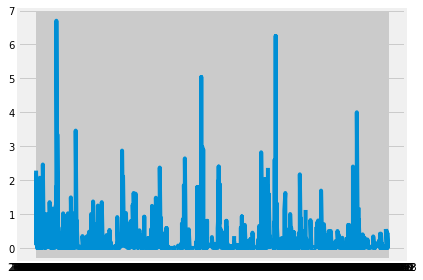

In [14]:
#dates = matplotlib.dates.date2num(date)
plt.plot(date,prcp)
plt.tight_layout()
plt.show()

In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
dfm = pd.read_sql('SELECT * FROM measurement',engine)
df_res = pd.read_sql('SELECT date, prcp FROM measurement where date > "2016-08-23"',engine)

# Sort the dataframe by date
df_res["date"] =pd.to_datetime(df_res.date)
df_res = df_res.sort_values(by="date", ascending = True)
df_res = df_res.set_index("date")
df_res.head()

,prcp
date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15


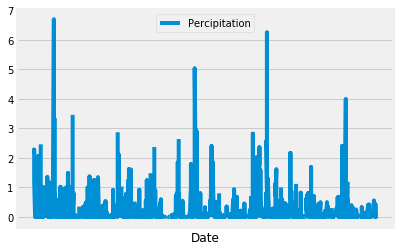

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(df_res["prcp"])
plt.xlabel("Date")
plt.xticks([])
plt.grid(True)
plt.legend(loc='upper center').get_texts()[0].set_text('Percipitation')
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
#difference comse from one day less in the df
df_res.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
# Design a query to show how many stations are available in this dataset?
stn = dfm["station"].nunique()
stn

9

In [19]:
stnq = session.query(Measurement.station).\
                        group_by(Measurement.station).count()
stnq

9

In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

acst = session.query(Measurement.station, func.count(Measurement.station)).\
                        group_by(Measurement.station).\
                        order_by(func.count(Measurement.station).desc())

acst[:]


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
sel = [Measurement.station,
       func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]

st_stats = session.query(*sel).\
        filter(Measurement.station == "USC00519281").all()

st_stats

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [22]:
# Choose the station with the highest number of temperature observations.
tmpst = session.query(Measurement.station, func.count(Measurement.tobs)).\
                        group_by(Measurement.station).\
                        order_by(func.count(Measurement.tobs).desc()).all()
tmpst

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [114]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tmpst1 = session.query( Measurement.date,Measurement.tobs ).\
                       filter(Measurement.station == "USC00519281", Measurement.date >"2016-08-23")

tmpst1[:]


[('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0),
 ('2016-09-02', 80.0),
 ('2016-09-03', 78.0),
 ('2016-09-04', 78.0),
 ('2016-09-05', 78.0),
 ('2016-09-06', 73.0),
 ('2016-09-07', 74.0),
 ('2016-09-08', 80.0),
 ('2016-09-09', 79.0),
 ('2016-09-10', 77.0),
 ('2016-09-11', 80.0),
 ('2016-09-12', 76.0),
 ('2016-09-13', 79.0),
 ('2016-09-14', 75.0),
 ('2016-09-15', 79.0),
 ('2016-09-16', 78.0),
 ('2016-09-17', 79.0),
 ('2016-09-18', 78.0),
 ('2016-09-19', 78.0),
 ('2016-09-20', 76.0),
 ('2016-09-21', 74.0),
 ('2016-09-22', 77.0),
 ('2016-09-23', 78.0),
 ('2016-09-24', 79.0),
 ('2016-09-25', 79.0),
 ('2016-09-26', 77.0),
 ('2016-09-27', 80.0),
 ('2016-09-28', 78.0),
 ('2016-09-29', 78.0),
 ('2016-09-30', 78.0),
 ('2016-10-01', 77.0),
 ('2016-10-02', 79.0),
 ('2016-10-03', 79.0),
 ('2016-10-04', 79.0),
 ('2016-10-05', 79.0),
 ('2016-10-

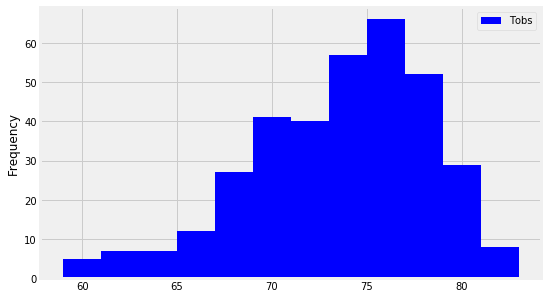

In [123]:
#Prepare DataFrame
df = pd.DataFrame(tmpst1[:], columns=['Date', 'Tobs'])
df.set_index(df['Date'], inplace=True)
df = df.drop(columns = 'Date')

#Prepare plot
fig, ax = plt.subplots(figsize=(8,5))
n, bins, patches = ax.hist(df['Tobs'], 12, color='blue')
ax.set_ylabel('Frequency')
ax.legend(prop={'size':10})

#Present plot
plt.show()

In [124]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates. 
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d     
    Returns:
        TMIN, TAVE, and TMAX
    """   
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [125]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

print(calc_temps("2016-08-10", "2016-08-23"))

[(71.0, 78.17582417582418, 83.0)]


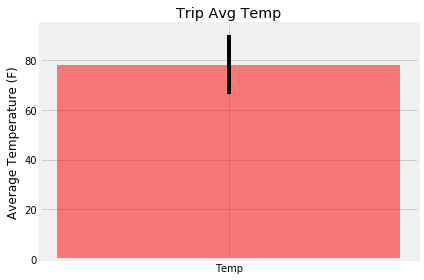

In [174]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x = calc_temps("2016-08-10", "2016-08-23")
x = x[0]
avg = x[1]
yerr = x[2]-x[0]

plt.bar('Temp',avg,align = 'center', width = 0.1, color = 'red',alpha = 0.5)
plt.errorbar(0,avg, yerr=yerr, color = 'black')

plt.ylabel('Average Temperature (F)')
plt.title('Trip Avg Temp')
plt.tight_layout()


plt.show()

In [197]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def rain(start_date, end_date):

    return session.query(Measurement.station,func.avg(Measurement.prcp), Station.latitude, Station.longitude, Station.elevation).\
                            join(Station, Measurement.station == Station.station).\
                                filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
                                group_by(Measurement.station).\
                                order_by(func.avg(Measurement.prcp).desc()).all()

rain('2012-02-28', '2012-03-05')

[('USC00519281', 1.582857142857143, 21.45167, -157.84888999999998, 32.9),
 ('USC00516128', 1.4742857142857144, 21.3331, -157.8025, 152.4),
 ('USC00518838', 0.9600000000000001, 21.4992, -158.0111, 306.6),
 ('USC00513117', 0.8271428571428572, 21.4234, -157.8015, 14.6),
 ('USC00519523', 0.41714285714285715, 21.33556, -157.71139, 19.5),
 ('USC00519397', 0.1685714285714286, 21.2716, -157.8168, 3.0),
 ('USC00511918', 0.10857142857142857, 21.3152, -157.9992, 0.9),
 ('USC00514830', 0.0075, 21.5213, -157.8374, 7.0),
 ('USC00517948', 0.0, 21.3934, -157.9751, 11.9)]